In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
%config InlineBackend.figure_format = 'svg'

In [2]:
concentrations_df = pd.read_csv('419_TiO_H2S_Concentrations.txt', sep='\t')
concentrations_df = concentrations_df[1:]

In [3]:
concentrations = np.array(concentrations_df)[:, 1]
names = np.array(concentrations_df)[:, 0]

In [4]:
curve_dict = {}

In [5]:
for i in range(0, len(names)):
    curve_dict[names[i]] = int(concentrations[i])

In [6]:
d = 'Curves'
dfs_dict = {}

for path in os.listdir(d):
    dfs = []
    pixel_path = os.path.join(d, path)
    
    for file in sorted(os.listdir(pixel_path), key=lambda x: int(x.split(' ')[0])):
        concentrations_list = []
        concentrations_list.append(curve_dict[file[:-4]])

        curve_path = os.path.join(pixel_path, file)
        df = pd.read_csv(curve_path, sep='\t')
        
        df['SDAmpers'][1:] = df['SDAmpers'][1:].apply(float)
        df['TimeStamp'][1:] = df['TimeStamp'][1:].apply(float)*0.001
        
        df['Concentrations'] = concentrations_list*len(df) 
        dfs.append(df[['TimeStamp', 'SDAmpers', 'Concentrations']][1:])

    dfs_dict[path] = dfs

In [7]:
from _plotly_future_ import v4_subplots 
from plotly.offline import init_notebook_mode, iplot
import plotly

import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

In [8]:
pixels = np.array(['Pixel 1', 'Pixel 3', 'Pixel 4', 'Pixel 5']).reshape(2,2)

fig = make_subplots(rows=2, cols=2, specs=[[{'secondary_y': True}, {'secondary_y': True}],
       [{'secondary_y': True}, {'secondary_y': True}]])

x = np.linspace(0, 166, 167).astype('int64')

for col in [1,2]:
    for row in [1,2]:
        y = [1/(dfs_dict[pixels[col-1][row-1]][i].SDAmpers.median()*1e8 + 3) for i in x]
        fig.add_trace(
                go.Scatter(
                    x = x,
                    y = y,
                    name = '{}'.format(pixels[col-1][row-1]),
                    mode = 'markers+lines',
                    marker = dict(symbol='square', color=concentrations.astype(int), colorscale="Rainbow", size=5),
                    line=dict(color='black', width=1, dash='dot')
            ),
                secondary_y=False,
                row=row, col=col
        )

        fig.add_trace(
                go.Scatter(
                    x = x,
                    y = concentrations.astype(int),
                    name = 'Concentrations'
            ),
                secondary_y=True,
                row=row, col=col

        )

        fig.update_xaxes(title_text="x")

        fig.update_yaxes(title_text="<b>pre. response</b>, a.u.", secondary_y=False)
        fig.update_yaxes(title_text="<b>Concentrations</b>, ppb", secondary_y=True)


fig.show()
fig.write_image("fig1.svg", width=1000, height=500)

In [9]:
traces = []
pixels = ['Pixel 1', 'Pixel 2', 'Pixel 3', 'Pixel 4', 'Pixel 5']

for N in [0, 25, 37, 47, 55, 66, 75, 115, 160]:
    for pixel in pixels:
        traces.append(
            go.Scatter(
                x=dfs_dict[pixel][N].TimeStamp,
                y=dfs_dict[pixel][N].SDAmpers, 
                name = 'P{}C{}'.format(pixel[-1], dfs_dict[pixel][N].Concentrations[1]),
                visible = (pixel == pixels[0]),
                mode = 'lines'
        ))

buttons = []
for N in range(0, len(pixels)): 
    buttons.append(
        dict(
             args=['visible', [False]*N + [True] + [False]*(len(pixels)-1-N)],
             label='{}'.format(pixels[N]),
             method='restyle'
        )
    )
        
layout = go.Layout(
    title='Зависимость тока от времени для разных концентраций. ',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=buttons
        ),
    ]),
)

fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

In [10]:
traces = []
pixels = ['Pixel 1', 'Pixel 3', 'Pixel 4', 'Pixel 5']

for pixel in pixels:
    for N in [0, 25, 37, 47, 55, 66, 75, 115, 160]:
        traces.append(
            go.Scatter(
                x=dfs_dict[pixel][N].TimeStamp,
                y=dfs_dict[pixel][N].SDAmpers, 
                name = 'P{}C{}'.format(pixel[-1], dfs_dict[pixel][N].Concentrations[1]),
                visible = (N == 0),
                mode = 'lines'
        ))

buttons = []
concentrations_list = [0, 100, 200, 500, 800, 1000, 1500, 80, 1]

for N in range(0, len(concentrations_list)): 
    buttons.append(
        dict(
             args=['visible', [False]*N + [True] + [False]*(len(concentrations_list)-1-N)],
             label='Concentration = {}'.format(concentrations_list[N]),
             method='restyle'
        )
    )        
        
layout = go.Layout(
    title='Сравнение кривых тока для разных датчиков при одной концентрации',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=buttons,
        )
    ]),
)

fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

In [11]:
traces = []
for N in np.linspace(0, 19, 7).astype('int64'):
    traces.append(
            go.Scatter(
                x = dfs_dict['Pixel 3'][N].TimeStamp,
                y = dfs_dict['Pixel 3'][N].SDAmpers,
                name = 'P{}C{}'.format('3', dfs_dict[pixel][N].Concentrations[1]),
                mode = 'lines'
            ))



layout = go.Layout(
    title='Сравнение кривой тока для одной концентрации и одного датчика (№3)',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1),
    ]))

fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

In [12]:
from itertools import groupby
l = [len(list(group)) for key, group in groupby(concentrations.astype(int))]

In [13]:
traces = []
pixels = ['Pixel 1', 'Pixel 3', 'Pixel 4', 'Pixel 5']
x = np.linspace(0, 166, 167).astype('int64')

for N in x:
    traces.append(
        go.Scatter(
            x=dfs_dict['Pixel 1'][N].TimeStamp,
            y=dfs_dict['Pixel 1'][N].SDAmpers, 
            name = 'P{}C{}'.format('1', dfs_dict[pixel][N].Concentrations[1]),
            visible = (N in x[:20]),
            mode = 'lines'
    ))

buttons = []
concentrations_list = [0, 100, 200, 500, 800, 1000, 1500, 80, 1]

for N in range(0, len(concentrations_list)): 
    buttons.append(
        dict(
             args=['visible', [concentrations_list[N]]*len(x) == concentrations.astype(int)],
             label='Concentration = {}'.format(concentrations_list[N]),
             method='restyle'
        )
    )        
        
layout = go.Layout(
    title='Сравнение кривых тока для датчика №3 при разных концентрациях',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=buttons,
        )
    ]),
)

fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

In [17]:
from scipy import stats

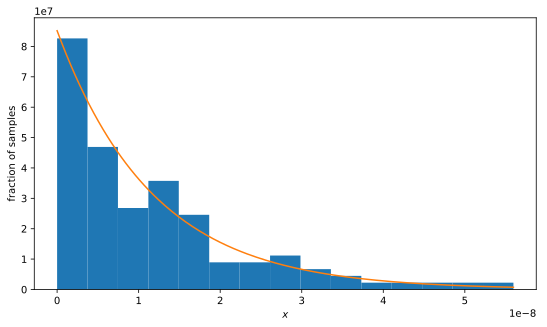

In [18]:
x = dfs_dict['Pixel 1'][0]['SDAmpers']
x = x.astype(float) - x.min()
sp = np.linspace(x.min(), x.max(), 200)
pdf = stats.expon(loc=x.min(), scale=x.mean()).pdf(sp)
plt.figure(figsize=(9,5))
plt.hist(x, density=True, bins=15)
plt.plot(sp, pdf)
plt.ylabel('fraction of samples')
plt.xlabel('$x$')
plt.savefig('fig4.png')

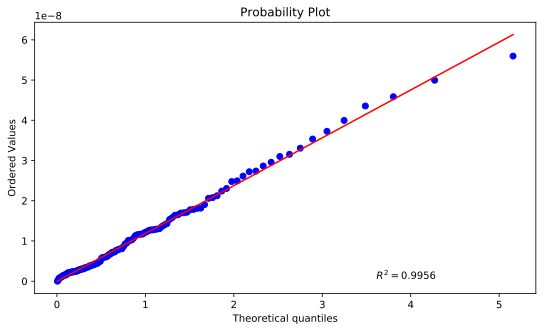

In [19]:
plt.figure(figsize=(9,5))
res = stats.probplot(x, plot=plt, dist='expon', rvalue=True)
plt.savefig('fig5.png')

In [86]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, A, beta, C0):
    return A*np.exp(-beta*x) + C0

y = dfs_dict['Pixel 4'][65]['SDAmpers'].astype(float)
x = dfs_dict['Pixel 4'][65]['TimeStamp'].astype(float)

popt, pcov = curve_fit(func, x, y, maxfev=10**6)    
A, beta, c = popt

print('A={0}\nbeta={1}\nc={2}'.format(*tuple(popt)))

A=1.2036756326835177e-08
beta=0.17938446297511443
c=5.241387039756473e-08


In [87]:
traces = []

traces.append(
    go.Scatter(
    x=x,
    y=y
    )
)

traces.append(
    go.Scatter(
            x=x,
            y=func(x, *popt)
    )
)


fig = {'data': traces}#, 'layout': layout}
iplot(fig, show_link=False)